In [1]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install elasticsearch
# !pip install pandasticsearch
# !pip install git+https://github.com/statsmodels/statsmodels

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import numpy as np
from numpy.linalg import inv
import pandas as pd
from elasticsearch import Elasticsearch
from pandasticsearch import Select
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

register_matplotlib_converters()

# Sleep test HI plot per session

## Ingest a combined (all sleep sessions) csv file

- Get results from elsatic and load into the dict
- Load into a df
- Plot session (plot label: user_name/workout_id, x-time, y-delta)

In [2]:
nbr_records = 3000
sessions = [561, 562]
index_name = "deltasstage"

es = Elasticsearch(host="ec2-35-166-165-103.us-west-2.compute.amazonaws.com", port="9200")
res_dict = es.search(index=index_name, 
                     body={
                         '_source': ['sessionid', 'delta', 'deltadt'],
                         "query": {
                             "bool": {
                                 "should": [
                                     {"match": {'sessionid': sessions[0]}},
                                     {"match": {'sessionid': sessions[1]}}
                                 ]
                              }
                         }, 
                         'size': nbr_records
                     })

# res_dict1 = es.search(index=index_name, 
#                      body={'_source': ['sessionid', 'delta', 'deltadt'],
#                      "query": {"match": {'sessionid': session_id}}, 
#                      'size': nbr_records})

df = Select.from_dict(res_dict).to_pandas()
df = df.sort_values(by=['sessionid', 'deltadt'])

In [3]:
# Split by session
dfs = {}
for session in sessions:
    print(session)
    dfs[session] = df[df['sessionid'] == str(session)]
    dfs[session]['date'] = pd.to_datetime(df['deltadt'])
    dfs[session]  = dfs[session].drop(['_index','_type', '_id', '_score', 'deltadt'], axis=1)
    dfs[session].loc[:,'delta'] *= 100
    dfs[session] = dfs[session].reset_index(drop=True)
    # localize from utc to pacific
#     dfs[session]['date'] = df['date'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific').dt.tz_localize(None)
#     dfs[session]  = dfs[session].drop(['_index','_type', '_id', '_score', 'deltadt'], axis=1)

561
562


/home/mshirman/Devel/JupyterNotebooks/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
dfs[561].head()
# df.dtypes

delta sessionid                date
0 -4.797791       561 2019-09-18 15:09:53
1 -3.622277       561 2019-09-18 15:10:03
2 -4.108912       561 2019-09-18 15:11:02
3 -3.681875       561 2019-09-18 15:12:01
4 -3.304591       561 2019-09-18 15:13:05

In [5]:
# convert 'date' to pandas date
# df['date'] = pd.to_datetime(df['deltadt'])

# df.dtypes
# df.head()

In [6]:
# Make deltaw into %
# df.loc[:,'delta'] *= 100

In [5]:
## Drop
# df.head()
# df  = df.drop(['_index','_type', '_id', '_score', 'deltadt'], axis=1)
# df.head()
# # localize from utc to pacific
# df['date'] = df['date'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific').dt.tz_localize(None)

# df.head()

## Let's generate the plot

In [6]:
sns.set(color_codes=True)
sns.set(style="darkgrid")

plt.figure(session_id, figsize=(14,4))
c = sns.lineplot(x='date', y='delta', style="sessionid", data=df, color="r")

c.set(xlabel='time', ylabel='% DeltaW')
    
for item in c.get_xticklabels():
    item.set_rotation(45)

NameError: name 'session_id' is not defined

## Show distribution, see outliers

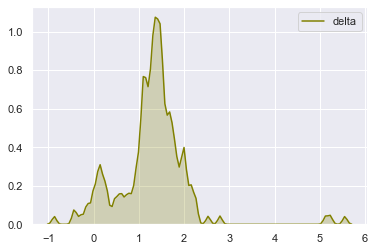

In [9]:
sns.kdeplot(df['delta'], shade=True, bw=.05, color="olive")

## Remove outliers

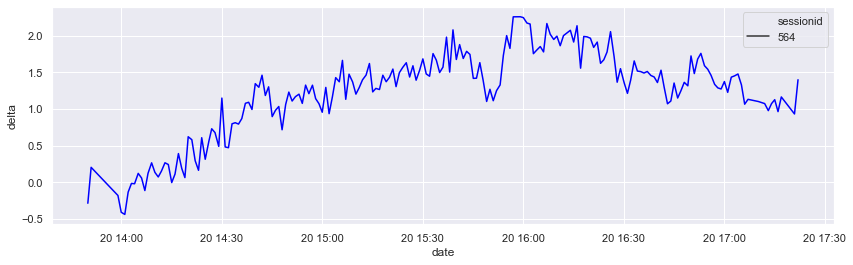

In [10]:
# Let's drop the outliers
idx_high = df[df['delta'] > 2.5].index
idx_low = df[df['delta'] < -.8].index

df_f = df.drop(idx_high)
df_f.drop(idx_low , inplace=True)

plt.figure(session_id, figsize=(14,4))
c = sns.lineplot(x='date', y='delta', style="sessionid", data=df_f, color="blue")


## Extract a given time range

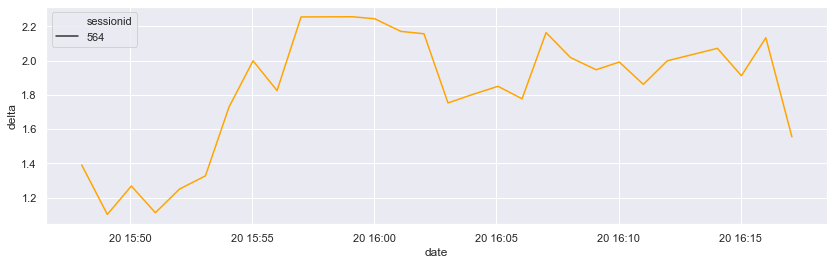

In [11]:
# Extract date range
dt_start = '09-20-2019 15:48:00'
dt_end = '09-20-2019 16:18:00'
mask = (df_f['date'] > dt_start) & (df_f['date'] <= dt_end)
df_dr = df_f.loc[mask]
plt.figure(session_id, figsize=(14,4))
c = sns.lineplot(x='date', y='delta', style="sessionid", data=df_dr, color="orange")


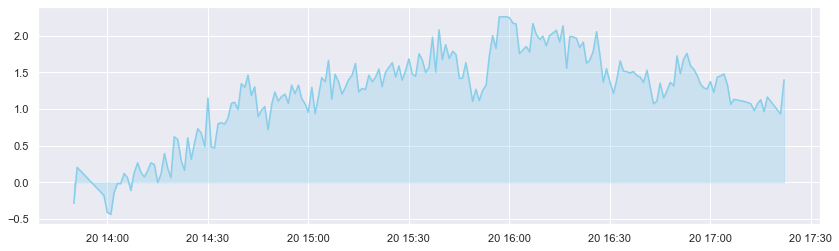

In [12]:
# sns.regplot(x='date', y='delta', data=df_new, fit_reg=True) 
y = df_f['delta']
x = df_f['date']

plt.figure(session_id, figsize=(14,4))

plt.fill_between(x, y, data=df_f, color="skyblue", alpha=0.3)
plt.plot(x, y, color="skyblue")


In [13]:
rows = len(df_f.index)
maxd = df_f['delta'].max()

x = np.linspace(0,  maxd, rows)
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)

beta = [.3, 0.5, -0.01]
sig = 0.5

w = np.ones(rows)
w[rows * 6//10:] = 3
y_true = np.dot(X, beta)

# y_true

## Draw fitted trendline

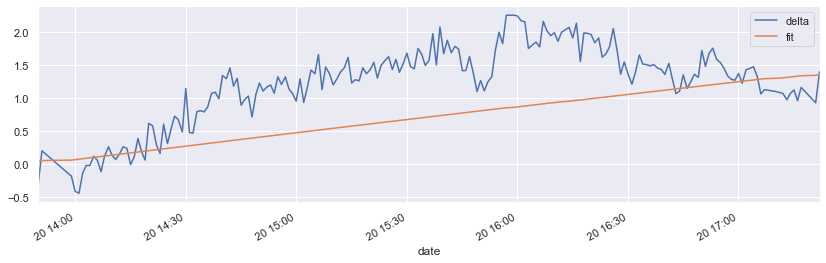

In [14]:
fig, ax = pyplot.subplots(figsize=(14,4))

df_f.plot(x='date', y='delta', ax=ax)
df_f.assign(fit=y_true).plot(x='date', y='fit', ax=ax)